# Evaluating triplet model

# Setting library path

In [182]:
import numpy as np
import pandas as pd
import os
import sys 

libpath = "lib"
sys.path.append(libpath)

# Configuration

In [199]:
DATASET_IMAGE_SIZE = (512, 512) # the image size in dataset loaded
EMBEDDING_INPUT_SHAPE = (128, 128, 3)
OUTPUT_DIMS = 15
BATCH_SIZE = 32

# Importing packages

In [200]:
if "texture_dataset" in sys.modules:
    del sys.modules["texture_dataset"]

from texture_dataset import load_texture_dataset, load_texture_dataset_as_dataframe

if "dataset_viz" in sys.modules:
    del sys.modules["dataset_viz"]

from dataset_viz import plot_dataset_samples

if "split_dataset" in sys.modules:
    del sys.modules["split_dataset"]

from split_dataset import split_dataset_by_pixel, split_dataset_by_pixel_as_dataframe

if "imgaug_model" in sys.modules:
    del sys.modules["imgaug_model"]

from imgaug_model import build_augmentation_model

if "imgaug_viz" in sys.modules:
    del sys.modules["imgaug_viz"]

from imgaug_viz import plot_augmented_samples, plot_augmented_samples_for_one_image

if "supervised_model" in sys.modules:
    del sys.modules["supervised_model"]

from supervised_model import build_supervised_model, SupervisedModelDataGeneratorFromXy

if "onenn_pred" in sys.modules:
    del sys.modules["onenn_pred"]

from onenn_pred import onenn_accuracy


if "split_keras_dataset_to_xy" in sys.modules:
    del sys.modules["split_keras_dataset_to_xy"]

from split_keras_dataset_to_xy import split_keras_dataset_to_xy

# Loading MBT dataset

In [46]:
from tensorflow import keras

dataset = keras.preprocessing.image_dataset_from_directory(
                "datasets_new/Multiband_Brodatz_Texture", 
                image_size = (128, 128), 
                #subset="training",
                #validation_split=0.2,
                batch_size = BATCH_SIZE,
                seed = 1234,
                shuffle=True
                )

Found 39424 files belonging to 154 classes.


In [48]:
#dataset.class_names

In [49]:
n_classes = len(dataset.class_names)
#n_samples = len(dataset.file_paths)
n_samples = len(dataset) * BATCH_SIZE
n_batches = len(dataset)

print("n_classes = ", n_classes)
print("n_samples = ", n_samples)
print("n_batches = ", n_batches)

n_classes =  154
n_samples =  39424
n_batches =  1232


# Splitting dataset

In [50]:
#dataset = dataset.shuffle(buffer_size = n_batches)

In [89]:
#
#    80% (training) + 20% (test)
#
# we keep 80% of the dataset as training
n_training_batches = np.int(0.8 * n_batches)
dataset_training = dataset.take(n_training_batches)

# we keep 10% of the dataset as testing
n_testing_batches = n_batches - n_training_batches
dataset_testing = dataset.skip(n_training_batches).take(n_testing_batches)

print("n_training_batches = ", n_training_batches)
print("n_testing_batches = ", n_testing_batches)

n_training_batches =  985
n_testing_batches =  247


In [68]:
#X_ = dataset_training.map(lambda x, y: x)
#y_ = dataset_training.map(lambda x, y: y)

In [87]:
#X = [Xi for Xi in X_]
#y = [yi for yi in y_]

#X = np.array(X)
#y = np.array(y)

#sample_shape = X.shape
#print(sample_shape)

#X = X.reshape(-1, *EMBEDDING_INPUT_SHAPE)
#y = y.reshape(-1)

#print(X.shape)
#print(y.shape)

In [97]:
X_train, y_train = split_keras_dataset_to_xy(dataset_training)

data_shape =  (128, 128, 3)
X.shape =  (31520, 128, 128, 3)
y.shape =  (31520,)


In [98]:
X_test, y_test = split_keras_dataset_to_xy(dataset_testing)

data_shape =  (128, 128, 3)
X.shape =  (7904, 128, 128, 3)
y.shape =  (7904,)


In [101]:
print(y_train[0])
print(dataset.class_names[y_train[0]])

50
Dz144


In [102]:
print(X_train[0].shape)

(128, 128, 3)


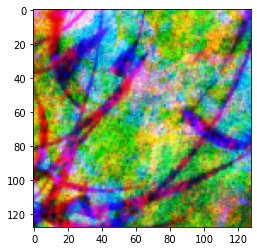

In [113]:
import matplotlib.pyplot as plt

plt.imshow(np.array(X_train[1], dtype = np.uint8))
plt.show()

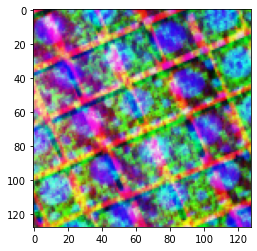

In [114]:
plt.imshow(np.array(X_test[1], dtype = np.uint8))
plt.show()

# Normalising

In [249]:
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

In [250]:
X_train /= 255
X_test /= 255

In [251]:
X_train[0]

array([[[0.07843138, 0.23137255, 0.81960785],
        [0.19215687, 0.6117647 , 0.7882353 ],
        [0.19215687, 0.68235296, 0.75686276],
        ...,
        [0.50980395, 0.33333334, 0.5764706 ],
        [0.42745098, 0.42745098, 0.5803922 ],
        [0.20392157, 0.5372549 , 0.6392157 ]],

       [[0.00784314, 0.92941177, 0.63529414],
        [0.02352941, 0.9529412 , 0.62352943],
        [0.01176471, 0.92156863, 0.69411767],
        ...,
        [0.4392157 , 0.7607843 , 0.6745098 ],
        [0.34117648, 0.8039216 , 0.7607843 ],
        [0.25882354, 0.8235294 , 0.84705883]],

       [[0.00784314, 0.9254902 , 0.8392157 ],
        [0.02745098, 0.8509804 , 0.8392157 ],
        [0.01176471, 0.8235294 , 0.87058824],
        ...,
        [0.34901962, 0.8745098 , 0.8666667 ],
        [0.4392157 , 0.7294118 , 0.9098039 ],
        [0.4       , 0.60784316, 0.90588236]],

       ...,

       [[0.14509805, 0.7176471 , 0.52156866],
        [0.09803922, 0.7764706 , 0.5411765 ],
        [0.07450981, 0

# 1-NN accuracy on raw data

In [112]:
n_train_samples = len(X_train)
X_train_ = X_train.reshape(n_train_samples, -1)

n_test_samples = len(X_test)
X_test_ = X_test.reshape(n_test_samples, -1)

onenn_accuracy(X_train_, y_train, X_test_, y_test)

(1.0, 0.006705465587044534)

# Triplet with simple embedding

In [282]:
if "triplet_model" in sys.modules:
    del sys.modules["triplet_model"]

from triplet_model import *

In [292]:
if "embedding_simple" in sys.modules:
    del sys.modules["embedding_simple"]

from embedding_simple import build_simple_embedding_model

In [293]:
#EMBEDDING_INPUT_SHAPE = (128, 128, 3)
#EMBEDDING_OUTPUT_DIMS = 10

In [305]:
OUTPUT_DIMS=5
embedding_model = build_simple_embedding_model(img_size = EMBEDDING_INPUT_SHAPE, 
                                               embedding_dim = OUTPUT_DIMS)
embedding_model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
global_max_pooling2d_4 (Glob (None, 32)                0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 32)              

In [306]:
embedding_model.layers[-1].output.shape

TensorShape([None, 5])

In [307]:
def get_triplet(X, y): 
    """Choose a triplet (anchor, positive, negative) of images
    such that anchor and positive have the same label and
    anchor and negative have different labels."""
    classes = sorted(list(set(y)))
    # choose two labels
    a, n = np.random.choice(classes, 2, replace=False)
    a_idxs = np.nonzero(y == a)[0] # indices where y == a
    n_idxs = np.nonzero(y == n)[0] # indices where y == n
    # choose two indices for (a, p) and one for n
    (a, p) = np.random.choice(a_idxs, 2, replace=False)
    n = np.random.choice(n_idxs, 1)
    return X[a], X[p], X[n] # get the images

def generate_triplets(X, y, batch_size):
    
    img_size = X[0].shape
    
    print("img_size = ", img_size)
    
    """Generate an un-ending stream of triplets for training or test."""
    while True:
        A = np.zeros((batch_size, *img_size), dtype="float32")
        P = np.zeros((batch_size, *img_size), dtype="float32")
        N = np.zeros((batch_size, *img_size), dtype="float32")

        for i in range(batch_size):
            a, p, n = get_triplet(X, y)
            A[i] = a
            P[i] = p
            N[i] = n
        yield [A, P, N]


In [308]:
#get_triplet(X_train, y_train)

In [309]:
triplet_model = build_triplet_model(embedding_model = embedding_model)


Building contrastive model with triplet loss ...
inputs_shape =  (128, 128, 3)


In [310]:
train_generator = generate_triplets(X_train, y_train, BATCH_SIZE)

In [ ]:
history = triplet_model.fit(
                  train_generator, 
                  epochs = 100,
                  steps_per_epoch=10,
                  validation_steps=1,
                  verbose = 1
                 )

img_size =  (128, 128, 3)
Epoch 1/100
10/10 [==============================] - 5s 436ms/step - loss: 0.5084
Epoch 2/100
10/10 [==============================] - 5s 552ms/step - loss: 0.4943
Epoch 3/100
10/10 [==============================] - 5s 468ms/step - loss: 0.5092
Epoch 4/100
10/10 [==============================] - 5s 462ms/step - loss: 0.5006
Epoch 5/100
10/10 [==============================] - 5s 474ms/step - loss: 0.4928
Epoch 6/100
10/10 [==============================] - 5s 468ms/step - loss: 0.5060
Epoch 7/100
10/10 [==============================] - 5s 474ms/step - loss: 0.4812
Epoch 8/100
10/10 [==============================] - 5s 546ms/step - loss: 0.4956
Epoch 9/100
10/10 [==============================] - 6s 559ms/step - loss: 0.5069
Epoch 10/100
10/10 [==============================] - 6s 561ms/step - loss: 0.4815
Epoch 11/100
10/10 [==============================] - 6s 563ms/step - loss: 0.4999
Epoch 12/100
10/10 [==============================] - 6s 589ms/step - 

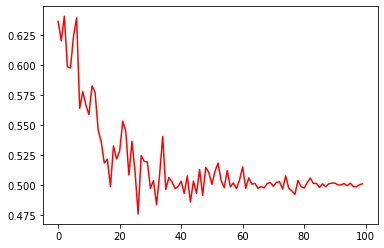

In [277]:
loss_hist = history.history["loss"]
plt.plot(loss_hist, color = "red")
plt.show()

In [278]:
#acc_hist = triplet_history.history["acc"]
#plt.plot(acc_hist, color = "blue")
#plt.show()

In [280]:
X_train_ = embedding_model.predict(X_train)
X_test_ = embedding_model.predict(X_test)

print(X_train_.shape)
print(X_test_.shape)



#X0 = X_train[0]
#X0 = np.expand_dims(X0, axis = 0)
#X0_ = embedding_model.predict(X0)
#X0_.shape
#embedding_model.layers[-1].output.shape

(31520, 15)
(7904, 15)


In [281]:
#X_train_.shape
onenn_accuracy(X_train_, y_train, X_test_, y_test)

accuracy on testing dataset:  0.006578947368421052


0.006578947368421052

# Triplet with VGG16

In [235]:
if "tsne_viz" in sys.modules:
    del sys.modules["tsne_viz"]

from tsne_viz import *

AttributeError: 'PathCollection' object has no property 'colour'

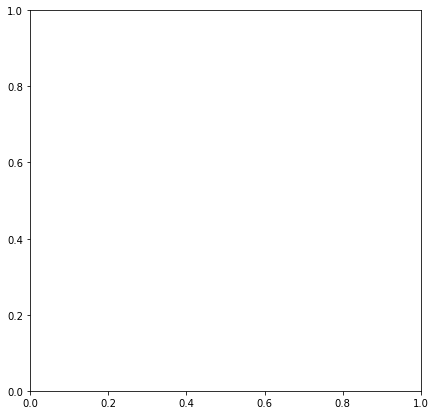

In [236]:
import random
indices = list(range(len(X_train)))
indices = np.random.choice(indices, 5, replace = False)

labels = y_train[indices]
features = X_train[indices]

#features, labels = sample_n_features(X, y, n, imgaug):
    
plot_tsne_proj(features, labels)